# Lab 5: Lab Hardware in Flyback Operation

#### Andrew Phillips

## Prelab: Create Digital Twin for Flyback Operation

In this prelab, I updated my digital twin to represent the flyback converter configuration of our lab hardware. As part of this update, I also designed an ideal transformer to meet the specified converter requirements:

- Input Voltage: 18V
- Output Voltage: 10V
- Output Power: 20W
- Switching Frequency: 50kHz
- Duty Cycle: 35%
- Alpha: 80%
- Assuming output capacitance of 60uF

These calculations are performed in the code block below, using equations derived from the buck-boost model developed in class. In order to use these equations, I converted the actual desired values of our flyback converter to equivalent buck-boost values by using the equations involving the turns ratio a derived in class.

I first determined that the converter is running in DCM, as the duty cycle is lower than the converter's voltage conversion ratio. I then used the DCM equations derived in class to calculate the converter's critical inductance, and then calculated the converter's inductance based on the given alpha value of 0.8. I then calculated the peak current through the inductor.

In [1]:
# import libraries
from math import sqrt

# Define parameters
Vg = 18 # V, input voltage
Vo = 10 # V, output voltage
W = 20 # W, output power
D = 0.35 # duty cycle
alpha = 0.8 # critical inductance ratio, L/Lcrit
Fs = 50e3 # Hz, switching frequency
Ts = 1/Fs # switching period

# Calculate voltage conversion ratio
Mo = Vo/Vg
print("Mo:", Mo)

# calculate for DCM
adcm = Mo*(sqrt(alpha)-D)/D

a = adcm # determined converter running in DCM, as duty cycle is below voltage conversion ratio
print("a:", a)
M = Mo/a # convert to buck-boost
print("M:", M)

V = 1/a*Vo # convert to buck-boost
print("V:", V)

# Calculate output load resistance
Iout = W/Vo # calculate output current
Ro = Vo/Iout # calculate output load resistance
print("Ro:", Ro)
R = (1/a**2)*Ro # convert to buck-boost
print ("R:", R)

# Calculate Lcrit
Lcrit = (1/(M+1))**2*R*Ts/2
print("Lcrit:", Lcrit)

# Calculate inductance
L = alpha*Lcrit
print("L:", L)

# Calculate peak current for DCM
Ipk = 2/sqrt(alpha)*(M+1)*V/R
print("Ipk:", Ipk)

Mo: 0.5555555555555556
a: 0.864170144444311
M: 0.642877515645713
V: 11.571795281622833
Ro: 5.0
R: 6.695322301989424
Lcrit: 2.4806249999999993e-05
L: 1.9844999999999997e-05
Ipk: 6.349206349206351


Based on these calculations, I determined that the converter is running in DCM and calculated a peak current of 6.34A. I verified this calculation with my updated PLECS model, a screenshot of which I have included below. The prelab PLECS model is also included in this submission.

![plecs_prelab](images/plecs_prelab.png)

Capturing a scope shot of the inductor current, I can see that the peak current through the inductor is ~6.3A, which matches with what I calculated in the prelab.

![prelab_scope](images/prelab_scope.png)

## Data Collection

During the lab, we swapped components around in our lab hardware to set it up for flyback operation mode. This involved moving our converter's main diode and a jumper connection. We then inserted the provided test transformer (T6) into our board and connected the load resistor and power supply, beginning to run the converter in flyback operation.

Lab Setup:

![lab_setup](images/lab_setup.jpg)

Board Closeup:

![board_closeup](images/board_closeup.jpg)

One observation we had while running experiments is that our output load voltage would slowly rise while running the converter. We realized that this is due to our load resistor heating up during operation, changing its resistance and its output voltage. After checking with Beat, we realized turning the resistor on its side allowed for much better ventilation for the resistor's fan, allowing the resistor to be cooled much more efficiently.

After taking traces at approximately 4V, 7V, and 9V output, we repeated these experiments to measure Vinj- and Vdd, which both measure the output voltage of the converter. For one of these measurements we switched the probe to AC coupling, and the other we kept in DC coupling to examine both AC and DC artifacts in the output voltage signal to calculate the output capacitance of the converter.

## Data Plotting: Lab Questions 1-8

In [3]:
# import necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

### Task 1 Plots:

Calculated turns ratio for 4.025V output: 0.7770270270270271
Calculated inductance for 4.025V output: 6.5765977443609005e-06
Calculated turns ratio for 7.03V output: 0.7934537246049659
Calculated inductance for 7.03V output: 5.517068273092368e-06
Calculated turns ratio for 9.00V output: 0.7880910683012256
Calculated inductance for 9.00V output: 4.687066974595844e-06
Averaged turns ratio value: 0.7861906066444062
Averaged inductance value: 5.593577664016371e-06


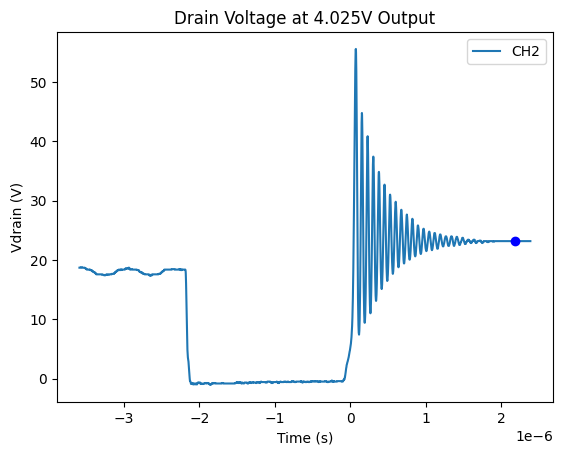

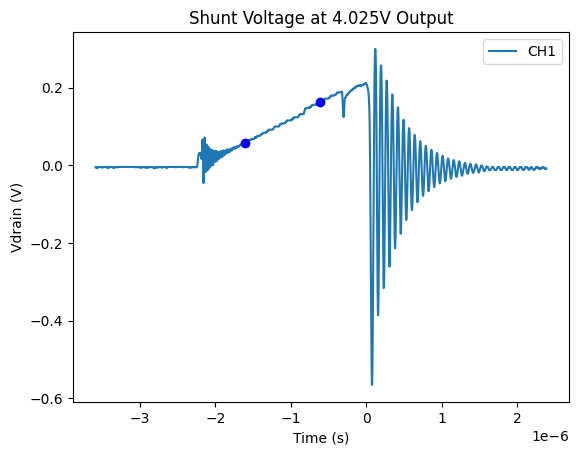

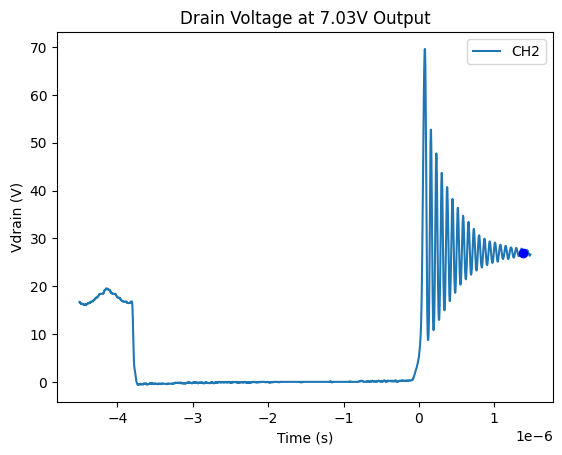

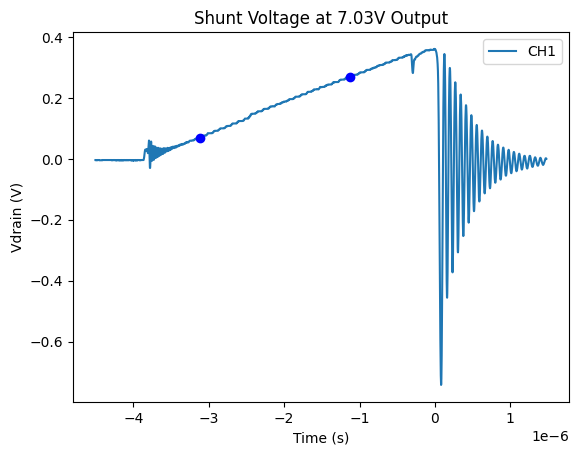

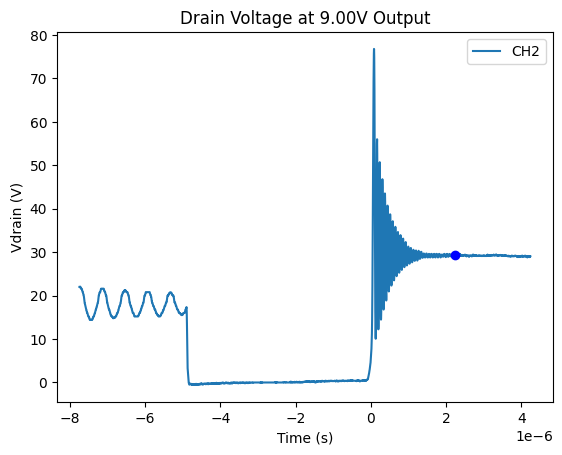

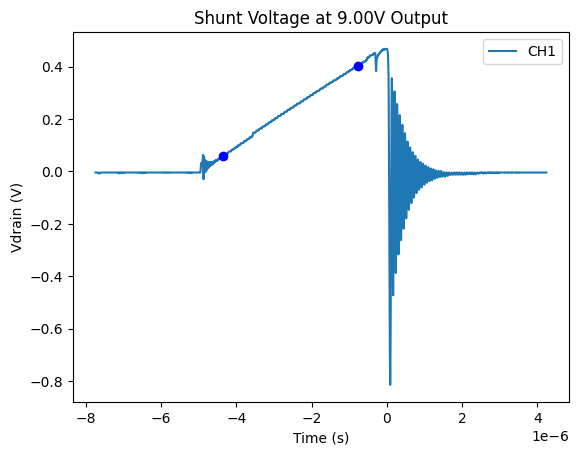

In [29]:
# data collection
# Task 1:
# CH1: Vshunt
# Ch2: Vdrain
# Power supply voltage: 18.02V
# 4V: 4.025V
# 7V: 7.03V
# 9V: 9.00V
Vin = 18.02 #V
Vout_4V = 4.025 #V
Vout_7V = 7.03 #V
Vout_9V = 9.00 #V

#4V
[inductor_data_4V, inductor_data_4V_t0, inductor_data_4V_dT] = read_rigol_csv('data/inductor_data_4V.csv')

#apply data filter
inductor_data_4V['CH1'] = inductor_data_4V['CH1'].rolling(10).mean()
inductor_data_4V['CH2'] = inductor_data_4V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_4V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 4.025V Output")
ax.plot(inductor_data_4V['X'].get(2900), inductor_data_4V['CH2'].get(2900), "bo")

# calculate turns ratio of test transformer
Vpk_4V = inductor_data_4V['CH2'].get(2900)
a_4V = Vout_4V/(Vpk_4V-Vin)
print("Calculated turns ratio for 4.025V output:", a_4V)


#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_4V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 4.025V Output")
ax.plot(inductor_data_4V['X'].get(1000), inductor_data_4V['CH1'].get(1000), "bo")
ax.plot(inductor_data_4V['X'].get(1500), inductor_data_4V['CH1'].get(1500), "bo")

# calculate magentizing inductance of test transformer
Rshunt = 0.05 #Ohms
dVdt_4V = (inductor_data_4V['CH1'].get(1500)-inductor_data_4V['CH1'].get(1000))/(inductor_data_4V['X'].get(1500)-inductor_data_4V['X'].get(1000))
dIdt_4V = dVdt_4V/Rshunt
Vl_4V = Vin-Vout_4V
L4V = Vl_4V/dIdt_4V
print("Calculated inductance for 4.025V output:", L4V)


#7V
[inductor_data_7V, inductor_data_7V_t0, inductor_data_7V_dT] = read_rigol_csv('data/inductor_data_7V.csv')

#apply data filter
inductor_data_7V['CH1'] = inductor_data_7V['CH1'].rolling(10).mean()
inductor_data_7V['CH2'] = inductor_data_7V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_7V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 7.03V Output")
ax.plot(inductor_data_7V['X'].get(2950), inductor_data_7V['CH2'].get(2950), "bo")

# calculate turns ratio of test transformer
Vpk_7V = inductor_data_7V['CH2'].get(2950)
a_7V = Vout_7V/(Vpk_7V-Vin)
print("Calculated turns ratio for 7.03V output:", a_7V)

#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_7V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 7.03V Output")
ax.plot(inductor_data_7V['X'].get(700), inductor_data_7V['CH1'].get(700), "bo")
ax.plot(inductor_data_7V['X'].get(1700), inductor_data_7V['CH1'].get(1700), "bo")

# calculate magentizing inductance of test transformer
dVdt_7V = (inductor_data_7V['CH1'].get(1700)-inductor_data_7V['CH1'].get(700))/(inductor_data_7V['X'].get(1700)-inductor_data_7V['X'].get(700))
dIdt_7V = dVdt_7V/Rshunt
Vl_7V = Vin-Vout_7V
L7V = Vl_7V/dIdt_7V
print("Calculated inductance for 7.03V output:", L7V)

#9V
[inductor_data_9V, inductor_data_9V_t0, inductor_data_9V_dT] = read_rigol_csv('data/inductor_data_9V.csv')

#apply data filter
inductor_data_9V['CH1'] = inductor_data_9V['CH1'].rolling(10).mean()
inductor_data_9V['CH2'] = inductor_data_9V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_9V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Drain Voltage at 9.00V Output")
ax.plot(inductor_data_9V['X'].get(5000), inductor_data_9V['CH2'].get(5000), "bo")

# calculate turns ratio of test transformer
Vpk_9V = inductor_data_9V['CH2'].get(5000)
a_9V = Vout_9V/(Vpk_9V-Vin)
print("Calculated turns ratio for 9.00V output:", a_9V)

#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_9V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Shunt Voltage at 9.00V Output")
ax.plot(inductor_data_9V['X'].get(3500), inductor_data_9V['CH1'].get(3500), "bo")
ax.plot(inductor_data_9V['X'].get(1700), inductor_data_9V['CH1'].get(1700), "bo")

# calculate magentizing inductance of test transformer
dVdt_9V = (inductor_data_9V['CH1'].get(3500)-inductor_data_9V['CH1'].get(1700))/(inductor_data_9V['X'].get(3500)-inductor_data_9V['X'].get(1700))
dIdt_9V = dVdt_9V/Rshunt
Vl_9V = Vin-Vout_9V
L9V = Vl_9V/dIdt_9V
print("Calculated inductance for 9.00V output:", L9V)

# Average turns ratio calculations
a_avg = (a_4V+a_7V+a_9V)/3
print("Averaged turns ratio value:", a_avg)

# Average inductance calculations
L_avg = (L4V+L7V+L9V)/3
print("Averaged inductance value:", L_avg)

### Task 2 Plots:

Cout, Vdd 4V output: 4.398924731182799e-05
Cout, Vinj 4V output: 4.363733333333326e-05
Cout, Vdd 7V output: 3.691099476439789e-05
Cout, Vinj 7V output: 3.569620253164548e-05
Cout, Vdd 9V output: 2.8994845360824738e-05
Cout, Vinj 9V output: 2.848101265822778e-05
Averaged output capacitance: 3.628493932670952e-05


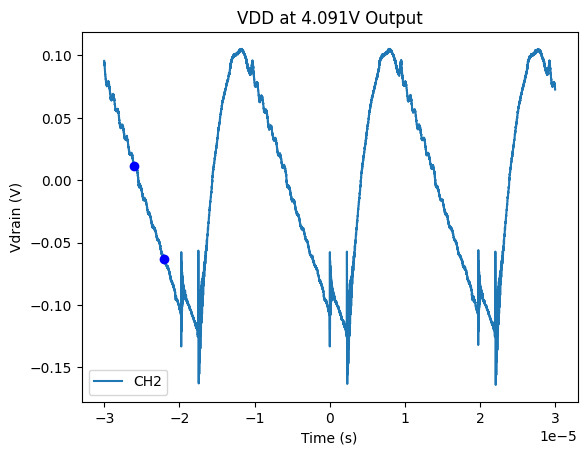

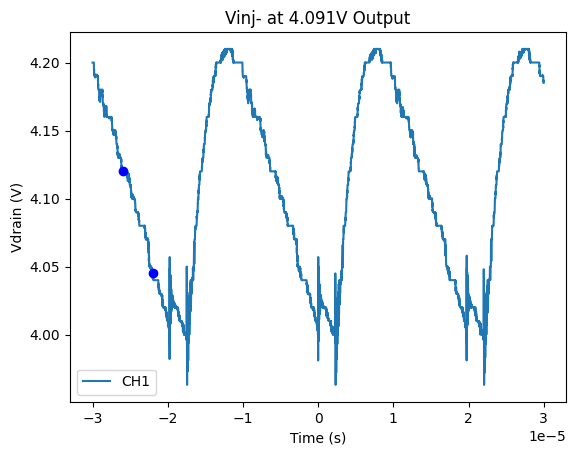

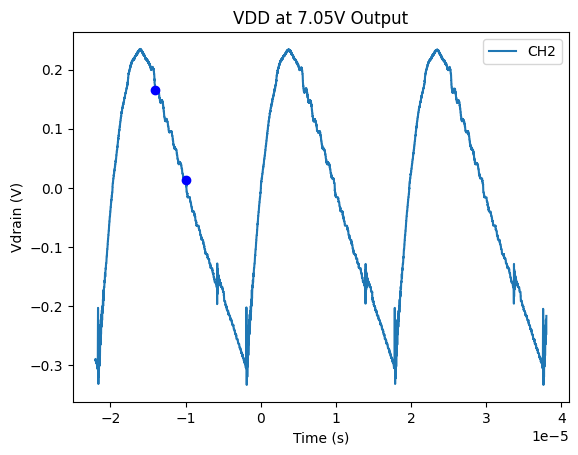

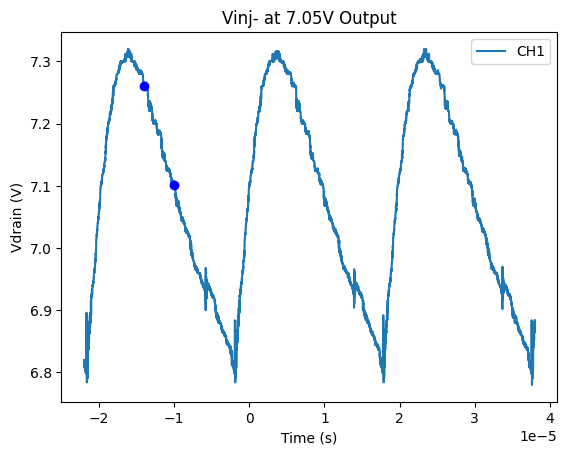

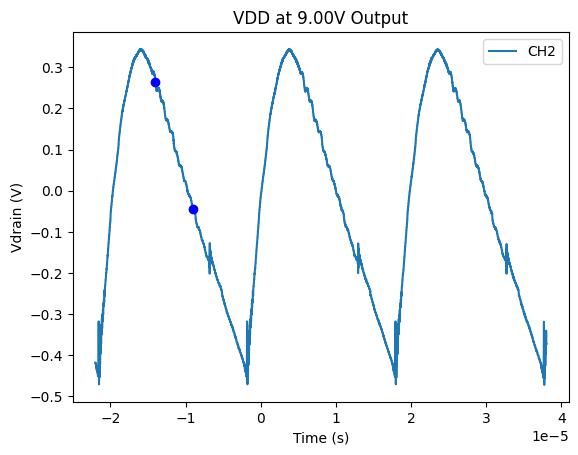

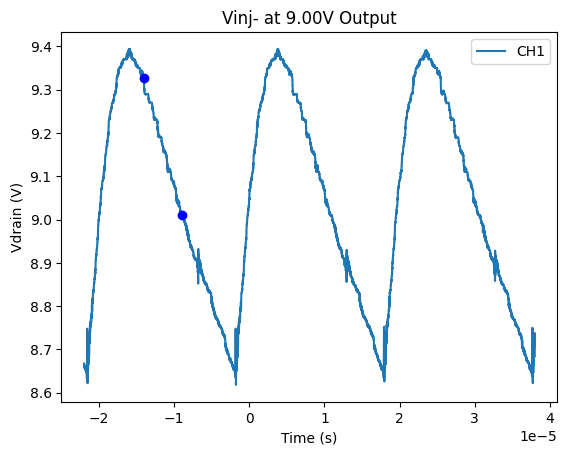

In [21]:
# Task 2
# CH1: VINJ-
# CH2: VDD
# 4V: 4.091V
# 7V: 7.05V
# 9V: 9.00V

Rout = 5 #Ohms
V4_out = 4.091 #V
V7_out = 7.05 #V
V9_out = 9.00 #V

#4V

[inductor_data_2_4V, inductor_data_2_4V_t0, inductor_data_2_4V_dT] = read_rigol_csv('data/inductor_data_2_4V.csv')

#apply data filter
inductor_data_2_4V['CH1'] = inductor_data_2_4V['CH1'].rolling(10).mean()
inductor_data_2_4V['CH2'] = inductor_data_2_4V['CH2'].rolling(10).mean()

#plot VDD voltage
fig, ax = plt.subplots()
inductor_data_2_4V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("VDD at 4.091V Output")
ax.plot(inductor_data_2_4V['X'].get(2000), inductor_data_2_4V['CH2'].get(2000), "bo")
ax.plot(inductor_data_2_4V['X'].get(4000), inductor_data_2_4V['CH2'].get(4000), "bo")

# calculate output capacitance
dVdt_vdd_4V = -(inductor_data_2_4V['CH2'].get(4000)-inductor_data_2_4V['CH2'].get(2000))/(inductor_data_2_4V['X'].get(4000)-inductor_data_2_4V['X'].get(2000)) # negated
I_vdd_4V = V4_out/Rout # calculate output current
C_vdd_4V = I_vdd_4V/dVdt_vdd_4V # calculate capacitance
print("Cout, Vdd 4V output:",C_vdd_4V)

#plot VINJ voltage
fig, ax = plt.subplots()
inductor_data_2_4V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Vinj- at 4.091V Output")
ax.plot(inductor_data_2_4V['X'].get(2000), inductor_data_2_4V['CH1'].get(2000), "bo")
ax.plot(inductor_data_2_4V['X'].get(4000), inductor_data_2_4V['CH1'].get(4000), "bo")

# calculate output capacitance
dVdt_vinj_4V = -(inductor_data_2_4V['CH1'].get(4000)-inductor_data_2_4V['CH1'].get(2000))/(inductor_data_2_4V['X'].get(4000)-inductor_data_2_4V['X'].get(2000)) # negated
I_vinj_4V = V4_out/Rout # calculate output current
C_vinj_4V = I_vinj_4V/dVdt_vinj_4V # calculate capacitance
print("Cout, Vinj 4V output:",C_vinj_4V)

#7V
[inductor_data_2_7V, inductor_data_2_7V_t0, inductor_data_2_7V_dT] = read_rigol_csv('data/inductor_data_2_7V.csv')

#apply data filter
inductor_data_2_7V['CH1'] = inductor_data_2_7V['CH1'].rolling(10).mean()
inductor_data_2_7V['CH2'] = inductor_data_2_7V['CH2'].rolling(10).mean()

#plot VDD voltage
fig, ax = plt.subplots()
inductor_data_2_7V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("VDD at 7.05V Output")
ax.plot(inductor_data_2_7V['X'].get(4000), inductor_data_2_7V['CH2'].get(4000), "bo")
ax.plot(inductor_data_2_7V['X'].get(6000), inductor_data_2_7V['CH2'].get(6000), "bo")

# calculate output capacitance
dVdt_vdd_7V = -(inductor_data_2_7V['CH2'].get(6000)-inductor_data_2_7V['CH2'].get(4000))/(inductor_data_2_7V['X'].get(6000)-inductor_data_2_7V['X'].get(4000)) # negated
I_vdd_7V = V7_out/Rout # calculate output current
C_vdd_7V = I_vdd_7V/dVdt_vdd_7V # calculate capacitance
print("Cout, Vdd 7V output:",C_vdd_7V)

#plot VINJ voltage
fig, ax = plt.subplots()
inductor_data_2_7V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Vinj- at 7.05V Output")
ax.plot(inductor_data_2_7V['X'].get(4000), inductor_data_2_7V['CH1'].get(4000), "bo")
ax.plot(inductor_data_2_7V['X'].get(6000), inductor_data_2_7V['CH1'].get(6000), "bo")

# calculate output capacitance
dVdt_vinj_7V = -(inductor_data_2_7V['CH1'].get(6000)-inductor_data_2_7V['CH1'].get(4000))/(inductor_data_2_7V['X'].get(6000)-inductor_data_2_7V['X'].get(4000)) # negated
I_vinj_7V = V7_out/Rout # calculate output current
C_vinj_7V = I_vinj_7V/dVdt_vinj_7V # calculate capacitance
print("Cout, Vinj 7V output:",C_vinj_7V)

#9V
[inductor_data_2_9V, inductor_data_2_9V_t0, inductor_data_2_9V_dT] = read_rigol_csv('data/inductor_data_2_9V.csv')

#apply data filter
inductor_data_2_9V['CH1'] = inductor_data_2_9V['CH1'].rolling(10).mean()
inductor_data_2_9V['CH2'] = inductor_data_2_9V['CH2'].rolling(10).mean()

#plot drain voltage
fig, ax = plt.subplots()
inductor_data_2_9V.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("VDD at 9.00V Output")
ax.plot(inductor_data_2_9V['X'].get(4000), inductor_data_2_9V['CH2'].get(4000), "bo")
ax.plot(inductor_data_2_9V['X'].get(6500), inductor_data_2_9V['CH2'].get(6500), "bo")

# calculate output capacitance
dVdt_vdd_9V = -(inductor_data_2_9V['CH2'].get(6500)-inductor_data_2_9V['CH2'].get(4000))/(inductor_data_2_9V['X'].get(6500)-inductor_data_2_9V['X'].get(4000)) # negated
I_vdd_9V = V9_out/Rout # calculate output current
C_vdd_9V = I_vdd_9V/dVdt_vdd_9V # calculate capacitance
print("Cout, Vdd 9V output:",C_vdd_9V)

#plot shunt voltage
fig, ax = plt.subplots()
inductor_data_2_9V.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Vinj- at 9.00V Output")
ax.plot(inductor_data_2_9V['X'].get(4000), inductor_data_2_9V['CH1'].get(4000), "bo")
ax.plot(inductor_data_2_9V['X'].get(6500), inductor_data_2_9V['CH1'].get(6500), "bo")

# calculate output capacitance
dVdt_vinj_9V = -(inductor_data_2_9V['CH1'].get(6500)-inductor_data_2_9V['CH1'].get(4000))/(inductor_data_2_9V['X'].get(6500)-inductor_data_2_9V['X'].get(4000)) # negated
I_vinj_9V = V9_out/Rout # calculate output current
C_vinj_9V = I_vinj_9V/dVdt_vinj_9V # calculate capacitance
print("Cout, Vinj 9V output:",C_vinj_9V)

# average output capacitance
C_out_avg = (C_vdd_4V+C_vdd_7V+C_vdd_9V+C_vinj_4V+C_vinj_7V+C_vinj_9V)/6
print("Averaged output capacitance:",C_out_avg)

7. Based on the shunt voltage measurements, I calculated a magentizing inductance of 5.594uH for the test transformer (T6) by averaging the results of each output setting, using the inductor current equation V=L*(di/dt).

8. The steady-state value of the drain voltage waveform after the FET opens but before the inductor finishes discharging is equivalent to Vg+Vo/a, as the output voltage is reflected back across the transformer according to the transformer's turns ratio. This reflected voltage adds to the input voltage, resulting in the stated equation. This can be rearranged to solve for the turns ratio a, resulting in the equation a=Vo/(Vpk-Vg). The script above calculates this value to be 0.786 by averaging the results of each output setting.

## Post-Lab Analysis

9. I updated my PLECS model to use the calculated inductance and turns ratio of the test transformer. The PLECS model is included in this submission. Note that the output voltages are negative due to the voltmeter being reversed. In the scope shots below, the top trace is the shunt voltage, the middle trace is the drain voltage, and the bottom trace is the output voltage.

~4V output simulation:

![4V_sim](images/4V_model_output.png)

~7V output simulation:

![7V_sim](images/7V_model_output.png)

~9V output simulation:

![9V_sim](images/9V_model_output.png)

I was initially surprised to see how much swing the output voltage had, but upon further reflection it makes sense that the output voltage signal is not relatively steady, as a single diode and a smoothing cap are the only components rectifying the AC output from the transformer (rather than something more robust like a full bridge rectifier). The general shape of the shunt and drain voltage waveforms match the data gathered in class, although without many of the artifacts of the physical lab hardware, such as the absence of ringing on the simulation's shunt and drain waveforms. The amplitudes and timing of my simulated shunt voltage waveforms also closely match my gathered lab data.

10. 

A. The simplifying assumptions made when studying the flyback converter seem valid. Modelling the transformer's inductance as a separate inductor on the primary side of the converter seems to match my actual results in lab. In addition, the equations developed to convert flyback values to equivalent buck-boost values seem to hold true to actual data, as my calculated peak current values using buck-boost equations match my simulated peak current in PLECS. My PLECS model, which abstracts the transformer inductance to a single inductor on the primary side (like the model in class), also matches the data I gathered using a real transformer in lab, also supporting that our simplifying results are valid.

B. When I initially measured my waveforms in PLECS, my simulated peak current and duty cycles did not seem to change across the 3 output voltage settings. I was initially confused, and thought it was due to the simulation not accounting for the resistances of other components in the circuit. This was unlikely to account for the disparity I was seeing, however. Upon further inspection, I realized that my PLECS model was dynamically calculating the output load resistance based on output power and output voltage parameters in the prelab. After changing this to the static value of 5 Ohms to match the lab hardware, my waveforms' peak current and duty cycles matched my physical waveforms much more closely. It goes to show that I should always double check my model between the prelab requirements and our actual lab hardware!

C. I see high frequency oscillations in the drain voltage when the FET is initially switched open and when the inductor fully finishes discharging. These ringing transients are caused by different resonances between the inductor's inductance value and the parasitic capacitances of various components in the circuit. The high frequency ringing when the FET opens is caused by resonance between the FET and the inductor, while the lower frequency ringing is caused by resonance between the diode on the converter's secondary side and the inductor. These high voltage transients could be significantly reduced by adding a snubber circuit to the converter design, which can help protect various components of the converter from experiencing significant overvoltage.

11. Based on the device properties of a capacitor, we can calculate the capacitance value using the equation i=C*(dV/dt), where i is the output current (which can be calculated by Ohm's law using the average output voltage across the load resistor) and dV/dt can be determined by finding the slope of the linear region of the output scope shots Vdd and Vinj-, both of which are measuring the output voltage. Note that the output voltage waveforms captured in lab are inverted compared to the PLECS model, so I negated the calculated dV/dt value to match the simulation. Calculating the output capacitance across all 6 captured output voltage waveforms and averaging the results resulted in an overall output capacitance value of 36.28uF. This is on the same order of magnitude as the simulated capacitance of 60uF. One observation I made is as the output voltage increased, the calculated output capacitance decreased. This may be due to the increased effect of the capacitor's internal resistance as the output voltage increases.